# Deep Learning with Python

## 3.5 Classifying newswires: a multiclass classification example

> 新闻分类: 多分类问题

[原文链接](https://livebook.manning.com/book/deep-learning-with-python/chapter-3/192)

3.4 节里我们不是把向量输入分成两类嘛，这节我们要把东西分成多类，即做“多分类（multi-class classification）”。

我们要把来自路透社的新闻分到 46 个话题种类里，
这里要求一条新闻只能属于一个类，所以具体来说，我们要做的是一个“单标签多分类（single-label, multiclass classification）”问题。

### 路透社数据集

the Reuters dataset，路透社在 1986 年（比我老多了😂）发布的数据集，里面有 46 类新闻，训练集里每类至少 10 条数据。

这个玩具数据集和 IMDB、MNIST 一样，也在  Keras 里内置了：

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2113536/2110848 [==============================] - 6s 3us/step


这个数据集里面的数据和之前的 IMDB 一样，把单词翻译成了数字，然后我们只截取出现频率最高的10000个词。

咱们这个训练集里有 8K+ 条数据，测试集 2K+：

In [5]:
print(len(train_data), len(test_data))

8982 2246


咱们还是像搞 IMDB 时那样，把数据还原会文本看看：

In [10]:
def decode_news(data):
    reverse_word_index = {v: k for k, v in reuters.get_word_index().items()}
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in data])
    # i - 3 是因为 0、1、2 为保留词 “padding”(填充)、“start of sequence”(序列开始)、“unknown”(未知词)


text = decode_news(train_data[0])
print(text)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


标签是 0~45 的数字：

In [11]:
train_labels[0]

3

### 数据准备

首先，还是把数据位向量化，直接套用我们搞 IMDB 时写的代码：

In [13]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

然后就是这种效果：

In [14]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

然后要处理标签。我们可以把标签处理成整数张量，也可以用 `One-hot` 编码
对于分类这种问题，我们常用 one-hot 编码（也叫*分类编码*，categorical encoding）。

对于我们当前的问题，使用 one-hot 编码，即用除了标签索引位置为 1 其余位置全为 0 的向量：

In [16]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results


one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

其实，，，Keras 里自带了一个可以干这个事情的函数：

In [23]:
from tensorflow.keras.utils import to_categorical
# 书上是 from keras.utils.np_utils import to_categorical 但，，，时代变了，而且咱这用的是 tensorflow.keras，所以稍微有点区别

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [24]:
one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 构建网络

这个问题和之前的电影评论分类问题还是差不多的，只是最后的解的可能从 2 -> 46，解空间大了太多了。

对于我们用的 Dense 层堆叠，每层都是接收上一层输出的信息作为输入。
所以，如果某一层丢失了一些信息，那么这些信息就再也不能被后面的层找回来了。
如果丢失的信息对分类没用，那这种丢失是好的、我们期望发生的；
但如果这些丢失的信息是对最后分类起作用的，那这种丢失就制约网络的结果了。
也就是说，这可能造成一种“信息瓶颈”。这种瓶颈在每一层都可能发生。

之前的电影评论分类最后只要 2 个结果，所以我们把层里的单元是用了 16 个，
即让机器在一个 16 维空间里学习，以及足够大了，不太会有“信息瓶颈“。

而我们现在的问题，解空间是 46 维的。
直接照搬之前的代码，让它在 16 维空间里学习，肯定有瓶颈！

解决瓶颈的办法很简单，直接增加层里的单元就好。这里我们是 16 -> 64:

In [25]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

在最后一层，我们的输出是 46 维的，对应 46 种分类，
而这一层的激活函数是 softmax，和我们在训练 MNIST 时用的一样。

用 softmax 可以让网络输出在 46 种分类上的概率分布，即一个 46 维的向量，
其中第 i 个元素代表输入属于第 i 种分类的可能性，
并且这 46 个元素的总和为 `1`。

### 编译模型

编译模型，又要确定损失函数、优化器和优化的目标了。

- 损失函数，分类问题嘛，还是用“分类交叉熵” categorical_crossentropy。
- 优化器，其实对很多问题我们都是用 rmsprop
- 目标还是一个，预测的精度 accuracy

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 验证效果

我们还是要搞一个验证集来在训练过程中评估模型的。从训练集里分个 1K 条数据出来就好：

In [27]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### 训练模型

好了，准备工作完成，又可以看到最迷人的训练过程了！

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 372us/sample - loss: 2.6180 - accuracy: 0.5150 - val_loss: 1.7517 - val_accuracy: 0.6290
Epoch 2/20
7982/7982 [==============================] - 1s 148us/sample - loss: 1.4632 - accuracy: 0.6899 - val_loss: 1.3370 - val_accuracy: 0.7120
Epoch 3/20
7982/7982 [==============================] - 1s 86us/sample - loss: 1.0988 - accuracy: 0.7628 - val_loss: 1.1418 - val_accuracy: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 87us/sample - loss: 0.8710 - accuracy: 0.8108 - val_loss: 1.0585 - val_accuracy: 0.7640
Epoch 5/20
7982/7982 [==============================] - 1s 90us/sample - loss: 0.6991 - accuracy: 0.8517 - val_loss: 0.9519 - val_accuracy: 0.8000
Epoch 6/20
7982/7982 [==============================] - 1s 102us/sample - loss: 0.5634 - accuracy: 0.8792 - val_loss: 0.9182 - val_accuracy: 0.8060
Epoch 7/20
7982/7982 [==============================] - 1s 88us/sam

🆗挺快的，照例，还是画图看看训练过程。

1. 训练过程中的损失

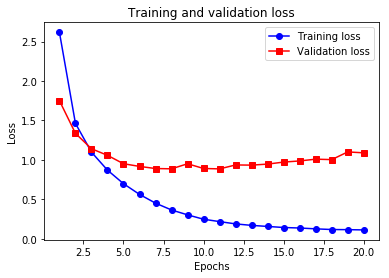

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. 训练过程中的精度

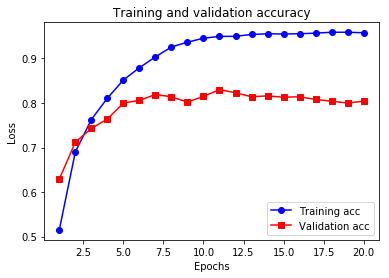

In [35]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Emmmm，说，第9轮 epochs 的时候开始过拟合了（你看validation的曲线抖在第9轮了一下）。
所以只要跑 9 轮就够了。

In [37]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 153us/sample - loss: 2.5943 - accuracy: 0.5515 - val_loss: 1.7017 - val_accuracy: 0.6410
Epoch 2/9
7982/7982 [==============================] - 1s 87us/sample - loss: 1.3850 - accuracy: 0.7102 - val_loss: 1.3064 - val_accuracy: 0.7280
Epoch 3/9
7982/7982 [==============================] - 1s 82us/sample - loss: 1.0315 - accuracy: 0.7813 - val_loss: 1.1210 - val_accuracy: 0.7520
Epoch 4/9
7982/7982 [==============================] - 1s 90us/sample - loss: 0.8110 - accuracy: 0.8282 - val_loss: 1.0099 - val_accuracy: 0.7990
Epoch 5/9
7982/7982 [==============================] - 1s 94us/sample - loss: 0.6407 - accuracy: 0.8671 - val_loss: 0.9611 - val_accuracy: 0.8080
Epoch 6/9
7982/7982 [==============================] - 1s 91us/sample - loss: 0.5147 - accuracy: 0.8926 - val_loss: 0.9399 - val_accuracy: 0.8030
Epoch 7/9
7982/7982 [==============================] - 1s 86us/sample - los

然后，用测试集测试一下:

In [39]:
results = model.evaluate(x_test, one_hot_test_labels, verbose=2)
print(results)

2246/1 - 0s - loss: 1.7611 - accuracy: 0.7912
[0.983459981976082, 0.7911843]


精度差不多 80%，其实还是不错的了，比随机瞎划线去分好多了。

如果随机划线去分类的话，对二元分类问题精度是 50 %，而对这 46 元的分类精度只要不到 19% 了：

In [40]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18432769367764915

调用 model 实例的 predict 方法，可以得到对输入在 46 个分类上的概率分布：

In [42]:
predictions = model.predict(x_test)
predictions

array([[4.7181980e-05, 2.0765587e-05, 8.6653872e-06, ..., 3.1266565e-05,
        8.2046267e-07, 6.0611728e-06],
       [5.9005950e-04, 1.3404934e-02, 1.2290048e-03, ..., 4.2919168e-05,
        5.7422225e-05, 4.0201416e-05],
       [8.5751421e-04, 9.2367262e-01, 1.5855590e-03, ..., 4.8341672e-04,
        4.5594123e-05, 2.6183401e-05],
       ...,
       [8.5679676e-05, 2.0081598e-04, 4.1808224e-05, ..., 7.6962686e-05,
        6.5783697e-06, 2.9889508e-05],
       [1.7291466e-03, 2.5600385e-02, 1.8182390e-03, ..., 1.4499390e-03,
        4.8478998e-04, 8.5257640e-04],
       [2.5776261e-04, 8.6797208e-01, 3.9900807e-03, ..., 2.6547859e-04,
        6.5820634e-05, 6.8603881e-06]], dtype=float32)

In [43]:
# 分别代表 46 个分类的可能
predictions[0].shape

(46,)

In [44]:
# 总和为 1
np.sum(predictions[0])

0.99999994

In [46]:
# 最大的，即我们认为这条新闻属于这个分类
np.argmax(predictions[0])

3

### 处理标签和损失的另一种方法

前面提到了标签可以使用 one-hot 编码，或者直接把标签处理成整数张量：

In [47]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

用这种的话，损失函数也要跟着改，改成 sparse_categorical_crossentropy，
这个和 categorical_crossentropy 在数学上是一样的，只是接口不同：

In [ ]:
 model.compile(optimizer='rmsprop',
               loss='sparse_categorical_crossentropy',
               metrics=['acc'])

### 中间层维度足够大的重要性

之前讨论了关于“信息瓶颈”的事，然后我们就说对这个 46 维结果的网络，中间层的维度要足够大！

现在咱试试如果不够大（导致信息瓶颈）会怎么样，咱搞夸张一点，从 64 减到 4：

In [48]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 288us/sample - loss: 2.8097 - accuracy: 0.4721 - val_loss: 2.0554 - val_accuracy: 0.5430
Epoch 2/20
7982/7982 [==============================] - 1s 117us/sample - loss: 1.7869 - accuracy: 0.5539 - val_loss: 1.6640 - val_accuracy: 0.5620
Epoch 3/20
7982/7982 [==============================] - 1s 125us/sample - loss: 1.4661 - accuracy: 0.6194 - val_loss: 1.4843 - val_accuracy: 0.6340
Epoch 4/20
7982/7982 [==============================] - 1s 120us/sample - loss: 1.2879 - accuracy: 0.6548 - val_loss: 1.4385 - val_accuracy: 0.6510
Epoch 5/20
7982/7982 [==============================] - 1s 108us/sample - loss: 1.1750 - accuracy: 0.6833 - val_loss: 1.4007 - val_accuracy: 0.6610
Epoch 6/20
7982/7982 [==============================] - 1s 123us/sample - loss: 1.0905 - accuracy: 0.7020 - val_loss: 1.4229 - val_accuracy: 0.6710
Epoch 7/20
7982/7982 [==============================] - 1s 126us

看看这，这训练出来比之前 64 维的差的不是一点半点哈，差距相当明显了。

发生这种效果的下降就是因为你给他学习的空间维度太低了，他把好多对分类有用的信息抛弃了。

那是不是越大越好？我们再试试把中间层加大一些：

In [51]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 273us/sample - loss: 1.5523 - accuracy: 0.6310 - val_loss: 1.1903 - val_accuracy: 0.7060
Epoch 2/20
7982/7982 [==============================] - 2s 199us/sample - loss: 0.8298 - accuracy: 0.7989 - val_loss: 0.9731 - val_accuracy: 0.7680
Epoch 3/20
7982/7982 [==============================] - 2s 198us/sample - loss: 0.5107 - accuracy: 0.8690 - val_loss: 0.9504 - val_accuracy: 0.7970
Epoch 4/20
7982/7982 [==============================] - 2s 240us/sample - loss: 0.3316 - accuracy: 0.9171 - val_loss: 1.0471 - val_accuracy: 0.7960
Epoch 5/20
7982/7982 [==============================] - 2s 226us/sample - loss: 0.2283 - accuracy: 0.9426 - val_loss: 1.2169 - val_accuracy: 0.7830
Epoch 6/20
7982/7982 [==============================] - 2s 225us/sample - loss: 0.1798 - accuracy: 0.9508 - val_loss: 1.0565 - val_accuracy: 0.7950
Epoch 7/20
7982/7982 [==============================] - 2s 230us

可以看到训练用的时间长了一点，电脑更暖手了一点，但效果却没有多大的提升。
这是由于第一层输入到中间层的只有 64 维嘛，中间层再大，也被第一层的瓶颈制约了。

在试试把第一层也加大！

In [54]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 5s 662us/sample - loss: 1.3423 - accuracy: 0.6913 - val_loss: 0.9565 - val_accuracy: 0.7920
Epoch 2/20
7982/7982 [==============================] - 5s 568us/sample - loss: 0.5307 - accuracy: 0.8805 - val_loss: 0.8447 - val_accuracy: 0.8110
Epoch 3/20
7982/7982 [==============================] - 5s 572us/sample - loss: 0.2874 - accuracy: 0.9296 - val_loss: 0.8745 - val_accuracy: 0.8050
Epoch 4/20
7982/7982 [==============================] - 5s 606us/sample - loss: 0.2037 - accuracy: 0.9469 - val_loss: 1.0001 - val_accuracy: 0.8100
Epoch 5/20
7982/7982 [==============================] - 5s 626us/sample - loss: 0.1651 - accuracy: 0.9510 - val_loss: 1.0603 - val_accuracy: 0.8160
Epoch 6/20
7982/7982 [==============================] - 5s 632us/sample - loss: 0.1443 - accuracy: 0.9530 - val_loss: 1.0834 - val_accuracy: 0.8070
Epoch 7/20
7982/7982 [==============================] - 5s 609us

（稍微小一点，本来是用 4096 的，但太大了，咱乞丐版 mbp 跑的贼慢，跑完要20多分钟，我懒得等）

这个多浪费了好多时间，而且他很快就~~过泥河~~过拟合了，过得还过得很严重，画个图看一下：

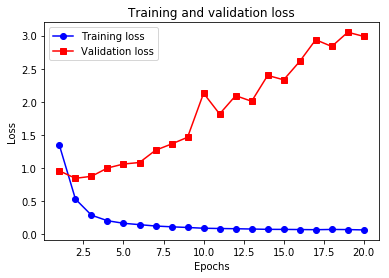

In [56]:
import matplotlib.pyplot as plt

loss = _.history['loss']
val_loss = _.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

所以，太大了也不好。还是要有个度！

### 尝试使用更少/更多的层

1. 更少的层

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 132us/sample - loss: 2.4611 - accuracy: 0.6001 - val_loss: 1.8556 - val_accuracy: 0.6440
Epoch 2/20
7982/7982 [==============================] - 1s 84us/sample - loss: 1.4246 - accuracy: 0.7150 - val_loss: 1.3749 - val_accuracy: 0.7130
Epoch 3/20
7982/7982 [==============================] - 1s 80us/sample - loss: 0.9778 - accuracy: 0.7920 - val_loss: 1.1532 - val_accuracy: 0.7590
Epoch 4/20
7982/7982 [==============================] - 1s 92us/sample - loss: 0.7302 - accuracy: 0.8507 - val_loss: 1.0373 - val_accuracy: 0.7870
Epoch 5/20
7982/7982 [==============================] - 1s 81us/sample - loss: 0.5789 - accuracy: 0.8819 - val_loss: 0.9836 - val_accuracy: 0.7960
Epoch 6/20
7982/7982 [==============================] - 1s 82us/sample - loss: 0.4793 - accuracy: 0.9039 - val_loss: 0.9633 - val_accuracy: 0.8030
Epoch 7/20
7982/7982 [==============================] - 1s 84us/sampl

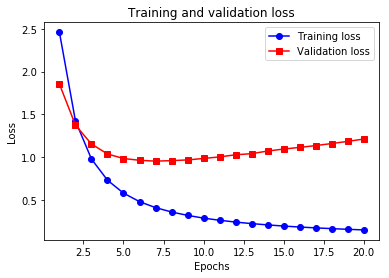

In [58]:
model = models.Sequential()
model.add(layers.Dense(46, activation='softmax', input_shape=(10000,)))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

快呀！结果稍微差了一点点。

2. 更多的层

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 188us/sample - loss: 1.8340 - accuracy: 0.5829 - val_loss: 1.3336 - val_accuracy: 0.6910
Epoch 2/20
7982/7982 [==============================] - 1s 102us/sample - loss: 1.0614 - accuracy: 0.7474 - val_loss: 1.1008 - val_accuracy: 0.7410
Epoch 3/20
7982/7982 [==============================] - 1s 97us/sample - loss: 0.7493 - accuracy: 0.8187 - val_loss: 1.1316 - val_accuracy: 0.7480
Epoch 4/20
7982/7982 [==============================] - 1s 101us/sample - loss: 0.5266 - accuracy: 0.8746 - val_loss: 1.0384 - val_accuracy: 0.7820
Epoch 5/20
7982/7982 [==============================] - 1s 102us/sample - loss: 0.3736 - accuracy: 0.9148 - val_loss: 1.1101 - val_accuracy: 0.7850
Epoch 6/20
7982/7982 [==============================] - 1s 100us/sample - loss: 0.2796 - accuracy: 0.9364 - val_loss: 1.3736 - val_accuracy: 0.7520
Epoch 7/20
7982/7982 [==============================] - 1s 110us/

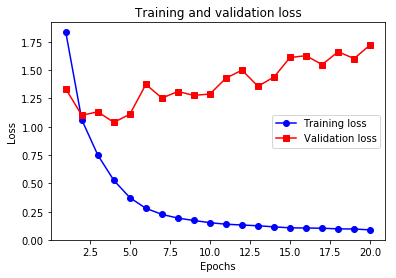

In [60]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

所以，这个也不是越多越好呀！